In [87]:
from IPython.display import clear_output
!pip install -U fsds_100719
clear_output()
from fsds_100719.imports import *


In [88]:
import warnings
warnings.filterwarnings('ignore')

# Functions

In [120]:
def evaluate_model(clf, y_trn, y_true, y_pred, X_trn, X_true):
    
    '''
    Calculates and displays the following: Train and Test Score, Classification Report, 
    Confusion Matrix, ROC Curve, and Importance Series.
    
        Parameters:
            
            clf: classifier or instanciated model from run_model function
            y_trn: y train from test, train, split
            y_true: y test from test, train, split
            y_pred: y hat test from run_model fuction
            X_trn: X train from test, train, split
            X_true: X test from test, train, split
    
    '''
    # Calculates and displays train and test scores.
    train_score = clf.score(X_trn,y_trn)
    test_score = clf.score(X_true,y_true)
    print(f"Train score= {train_score}")
    print(f"Test score= {test_score}")
    
    # Displays Classification Report / Scores 
    print(metrics.classification_report(y_true,y_pred))
    
    # Displays Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,4),ncols=2)
    metrics.plot_confusion_matrix(clf,X_true,y_true,cmap="Reds",
                                  normalize='true',ax=ax[0])
    ax[0].set(title='Confusion Matrix')
    ax[0].grid(False)
    y_score = clf.predict_proba(X_true)[:,1]
    
    # Calculates and displays ROC Curve
    fpr,tpr,thresh = metrics.roc_curve(y_true,y_score)
    roc_auc = round(metrics.auc(fpr,tpr),3)
    ax[1].plot(fpr,tpr,color='darkorange',label=f'ROC Curve (AUC={roc_auc})')
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].legend()
    ax[1].grid()
    ax[1].set(ylabel='True Positive Rate',xlabel='False Positive Rate',title='Receiver operating characteristic (ROC) Curve')
    plt.tight_layout()
    plt.show()

    # Calculates and displays Feature Importances.
    df_import = pd.Series(clf.feature_importances_, index = X_train.columns,name='Importance')
    print(df_import.sort_values(ascending=False).head())

# EDA

In [89]:
data = pd.read_csv('product_review.csv',encoding= 'unicode_escape')

In [90]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [91]:
data.rename(columns={'tweet_text': 'tweet', 'emotion_in_tweet_is_directed_at': 'product', 'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace=True)

In [92]:
data.shape

(9093, 3)

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet      9092 non-null object
product    3291 non-null object
emotion    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [94]:
data.isnull().sum()

tweet         1
product    5802
emotion       0
dtype: int64

In [95]:
data.fillna('unknown', inplace=True)

In [98]:
data['emotion'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [99]:
data.isnull().sum()

tweet      0
product    0
emotion    0
dtype: int64

In [97]:

# data.dropna(inplace=True)

# blanks = []  

# for i,twt,prod,emo in data.itertuples():  
#     if type(twt)==str:            
#         if twt.isspace():         
#             blanks.append(i)     
# data.drop(blanks, inplace=True)

In [12]:
data["tweet"]= data["tweet"].astype(str) 

In [13]:
data['text length'] = data['tweet'].apply(len)

In [14]:
data['token_length'] = [len(x.split(" ")) for x in data.tweet]
max(data.token_length)

33

In [15]:
data.isnull().sum()

tweet           0
product         0
emotion         0
text length     0
token_length    0
dtype: int64

In [16]:
data.shape

(9093, 5)

In [17]:
data['emotion'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [18]:
bad_rows = data['emotion']== "I can't tell"

In [19]:
data = data[~bad_rows]

In [20]:
data['emotion'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

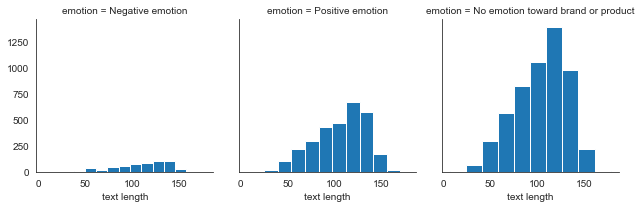

In [22]:
a = sns.FacetGrid(data,col='emotion')
a.map(plt.hist,'text length')

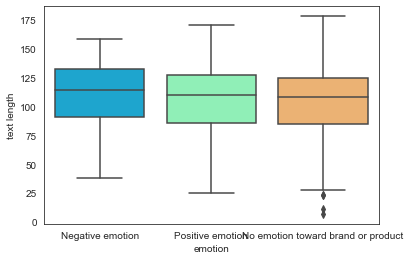

In [23]:
sns.boxplot(x='emotion',y='text length',data=data,palette='rainbow')

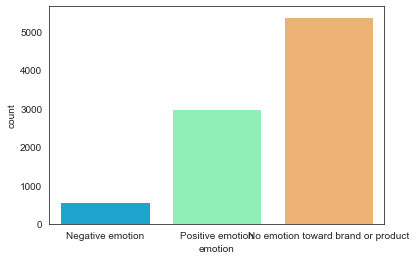

In [24]:
sns.countplot(x='emotion',data=data,palette='rainbow')

# Train/Test/Split

In [25]:
from sklearn.model_selection import train_test_split

X = data['tweet']
y = data['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size=0.30, random_state=123)

In [82]:
def plot_confusion_matrix(conf_matrix, classes = None, normalize=True,
                          title='Confusion Matrix', cmap="Blues",
                          print_raw_matrix=False,
                          fig_size=(4,4)):
    """Check if Normalization Option is Set to True. 
    If so, normalize the raw confusion matrix before visualizing
    #Other code should be equivalent to your previous function.
    Note: Taken from bs_ds and modified
    - Can pass a tuple of (y_true,y_pred) instead of conf matrix.
    """
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    import sklearn.metrics as metrics
    
    ## make confusion matrix if given tuple of y_true,y_pred
    if isinstance(conf_matrix, tuple):
        y_true = conf_matrix[0].copy()
        y_pred = conf_matrix[1].copy()
        
        if y_true.ndim>1:
            y_true = y_true.argmax(axis=1)
        if y_pred.ndim>1:
            y_pred = y_pred.argmax(axis=1)
        cm = metrics.confusion_matrix(y_true,y_pred)
    else:
        cm = conf_matrix
        
    ## Generate integer labels for classes
    if classes is None:
        classes = list(range(len(cm)))  
        
    ## Normalize data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt='.2f'
    else:
        fmt= 'd'
        
        
    fontDict = {
        'title':{
            'fontsize':16,
            'fontweight':'semibold',
            'ha':'center',
            },
        'xlabel':{
            'fontsize':14,
            'fontweight':'normal',
            },
        'ylabel':{
            'fontsize':14,
            'fontweight':'normal',
            },
        'xtick_labels':{
            'fontsize':10,
            'fontweight':'normal',
    #             'rotation':45,
            'ha':'right',
            },
        'ytick_labels':{
            'fontsize':10,
            'fontweight':'normal',
            'rotation':0,
            'ha':'right',
            },
        'data_labels':{
            'ha':'center',
            'fontweight':'semibold',

        }
    }

    # Create plot
    fig,ax = plt.subplots(figsize=fig_size)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,**fontDict['title'])
    plt.colorbar()

    tick_marks = classes#np.arange(len(classes))


    plt.xticks(tick_marks, classes, **fontDict['xtick_labels'])
    plt.yticks(tick_marks, classes,**fontDict['ytick_labels'])

    # Determine threshold for b/w text
    thresh = cm.max() / 2.

    # fig,ax = plt.subplots()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 color='darkgray',**fontDict['data_labels']) #color="white" if cm[i, j] > thresh else "black"

    plt.tight_layout()
    plt.ylabel('True label',**fontDict['ylabel'])
    plt.xlabel('Predicted label',**fontDict['xlabel'])

    if print_raw_matrix:
        print_title = 'Raw Confusion Matrix Counts:'
        print('\n',print_title)
        print(conf_matrix)


    fig = plt.gcf()
    return fig

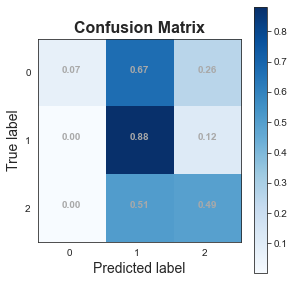

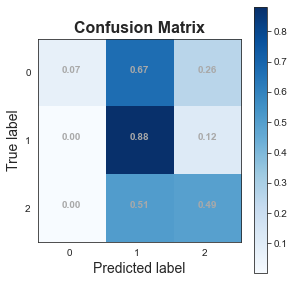

In [85]:
plot_confusion_matrix(cm)

In [109]:
cm = (metrics.confusion_matrix(y_test,predictions))
cm

array([[  25,  122,   24],
       [  10, 1441,  166],
       [   1,  548,  345]])

In [38]:

# testing_tfidf = tfidf.fit_transform(X_train)

# ros = RandomOverSampler(random_state=777)
# X_ROS, y_ROS = ros.fit_sample(testing_tfidf, y_train)

In [39]:
# df = pd.DataFrame(y_ROS)
# df.columns = ['emotion']
# df.head()


In [40]:
# df['emotion'].value_counts()

# LinearSVC

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from nltk import TweetTokenizer
from imblearn.metrics import classification_report_imbalanced


In [41]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',tokenizer=tokenizer.tokenize)),
                     ('clf', LinearSVC(class_weight='balanced'))])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x1c25f38320>>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight='balanced', dual=T

In [42]:
# Form a prediction set
predictions = text_clf.predict(X_test)

## Metrics

In [43]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[  63   69   39]
 [  56 1252  309]
 [  17  355  522]]


In [44]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

                                    precision    recall  f1-score   support

                  Negative emotion       0.46      0.37      0.41       171
No emotion toward brand or product       0.75      0.77      0.76      1617
                  Positive emotion       0.60      0.58      0.59       894

                          accuracy                           0.68      2682
                         macro avg       0.60      0.58      0.59      2682
                      weighted avg       0.68      0.68      0.68      2682



In [45]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.6849366144668159


# LinearSVC - RandomOverSampler, 
# SMOTE, ADASYN

In [110]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler


tokenizer = TweetTokenizer(preserve_case=False)

tfidf = TfidfVectorizer(lowercase=True, stop_words='english',
                            tokenizer=tokenizer.tokenize)

svc = LinearSVC(class_weight='balanced')

ROS_pipeline = make_pipeline(tfidf, RandomOverSampler(random_state=123),
                              svc)
SMOTE_pipeline = make_pipeline(tfidf, SMOTE(random_state=123),svc)
ADASYN_pipeline = make_pipeline(tfidf, ADASYN(ratio='minority',random_state=123),svc)

In [32]:
ROS_pipeline.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,...
                                 use_idf=True, vocabulary=None)),
                ('randomoversampler',
                 RandomOverSampler(random_state=123, ratio=None,
                                   return_indices=False,
                                   sampling_strategy='auto')),
                ('linearsvc',
                 

In [33]:
# Form a prediction set
predictions = ROS_pipeline.predict(X_test)

In [35]:
from sklearn import metrics

## Metrics

In [119]:

cri = classification_report_imbalanced(y_test,predictions)
cri

'                                          pre       rec       spe        f1       geo       iba       sup\n\n                  Negative emotion       0.69      0.15      1.00      0.24      0.38      0.13       171\nNo emotion toward brand or product       0.68      0.89      0.37      0.77      0.57      0.35      1617\n                  Positive emotion       0.64      0.39      0.89      0.48      0.59      0.33       894\n\n                       avg / total       0.67      0.68      0.59      0.64      0.57      0.33      2682\n'

In [37]:
print(metrics.classification_report(y_test,predictions))

                                    precision    recall  f1-score   support

                  Negative emotion       0.41      0.39      0.40       171
No emotion toward brand or product       0.75      0.75      0.75      1617
                  Positive emotion       0.58      0.59      0.59       894

                          accuracy                           0.67      2682
                         macro avg       0.58      0.58      0.58      2682
                      weighted avg       0.67      0.67      0.67      2682



# MulitinomialNB

In [46]:
from sklearn.naive_bayes import MultinomialNB

In [47]:
text_mnb = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',tokenizer=tokenizer.tokenize)),
                     ('clf', MultinomialNB())])

# Feed the training data through the pipeline
text_mnb.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x1c25f38320>>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, cl

In [48]:
# Form a prediction set
predictions = text_mnb.predict(X_test)

## Metrics

In [49]:
print(metrics.confusion_matrix(y_test,predictions))

[[   1  157   13]
 [   0 1563   54]
 [   0  707  187]]


In [50]:
print(metrics.classification_report(y_test,predictions))

                                    precision    recall  f1-score   support

                  Negative emotion       1.00      0.01      0.01       171
No emotion toward brand or product       0.64      0.97      0.77      1617
                  Positive emotion       0.74      0.21      0.33       894

                          accuracy                           0.65      2682
                         macro avg       0.79      0.39      0.37      2682
                      weighted avg       0.70      0.65      0.58      2682



In [51]:
y_test.value_counts()

No emotion toward brand or product    1617
Positive emotion                       894
Negative emotion                       171
Name: emotion, dtype: int64

In [52]:
y_train.value_counts()

No emotion toward brand or product    3772
Positive emotion                      2084
Negative emotion                       399
Name: emotion, dtype: int64

# SGDClassifier

In [53]:
from sklearn.linear_model import SGDClassifier

In [54]:
text_sgdc = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',tokenizer=tokenizer.tokenize)),
                     ('clf', SGDClassifier())])

# Feed the training data through the pipeline
text_sgdc.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
           

In [55]:
# Form a prediction set
predictions = text_sgdc.predict(X_test)

## Metrics

In [56]:
print(metrics.confusion_matrix(y_test,predictions))

[[  44   88   39]
 [  19 1355  243]
 [   5  422  467]]


In [57]:
print(metrics.classification_report(y_test,predictions))

                                    precision    recall  f1-score   support

                  Negative emotion       0.65      0.26      0.37       171
No emotion toward brand or product       0.73      0.84      0.78      1617
                  Positive emotion       0.62      0.52      0.57       894

                          accuracy                           0.70      2682
                         macro avg       0.67      0.54      0.57      2682
                      weighted avg       0.69      0.70      0.68      2682



# LogisticRegression

In [58]:

from sklearn.linear_model import LogisticRegression

In [59]:
text_lr = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',tokenizer=tokenizer.tokenize)),
                     ('clf', LogisticRegression())])

# Feed the training data through the pipeline
text_lr.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x1c25f38320>>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dua

In [60]:
# Form a prediction set
predictions = text_lr.predict(X_test)

## Metrics

In [61]:
print(metrics.confusion_matrix(y_test,predictions))

[[  12  115   44]
 [   6 1422  189]
 [   1  453  440]]


In [62]:
print(metrics.classification_report(y_test,predictions))

                                    precision    recall  f1-score   support

                  Negative emotion       0.63      0.07      0.13       171
No emotion toward brand or product       0.71      0.88      0.79      1617
                  Positive emotion       0.65      0.49      0.56       894

                          accuracy                           0.70      2682
                         macro avg       0.67      0.48      0.49      2682
                      weighted avg       0.69      0.70      0.67      2682



# RandomForestClassifier

In [100]:
from sklearn.ensemble import RandomForestClassifier

In [123]:
rfc = RandomForestClassifier()

In [105]:
text_rfc = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',tokenizer=tokenizer.tokenize)),
                     ('clf', RandomForestClassifier(class_weight='balanced'))])

# Feed the training data through the pipeline
text_rfc.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                               

In [106]:
# Form a prediction set
predictions = text_rfc.predict(X_test)

## Metrics

In [107]:
print(metrics.confusion_matrix(y_test,predictions))

[[  25  122   24]
 [  10 1441  166]
 [   1  548  345]]


In [108]:
print(metrics.classification_report(y_test,predictions))

                                    precision    recall  f1-score   support

                  Negative emotion       0.69      0.15      0.24       171
No emotion toward brand or product       0.68      0.89      0.77      1617
                  Positive emotion       0.64      0.39      0.48       894

                          accuracy                           0.68      2682
                         macro avg       0.67      0.47      0.50      2682
                      weighted avg       0.67      0.68      0.64      2682



Train score= 0.9979216626698642
Test score= 0.6752423564504102
                                    precision    recall  f1-score   support

                  Negative emotion       0.69      0.15      0.24       171
No emotion toward brand or product       0.68      0.89      0.77      1617
                  Positive emotion       0.64      0.39      0.48       894

                          accuracy                           0.68      2682
                         macro avg       0.67      0.47      0.50      2682
                      weighted avg       0.67      0.68      0.64      2682



ValueError: multiclass format is not supported

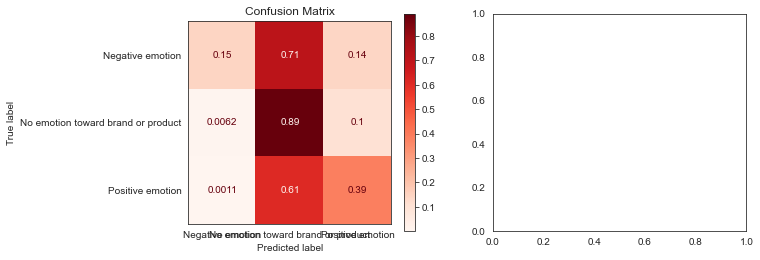

In [125]:
evaluate_model(text_rfc, y_train, y_test, predictions, X_train, X_test)

In [63]:
# tfid = TfidfVectorizer()

In [64]:
# tokenizer = TweetTokenizer()

In [65]:
# tfid = TfidfVectorizer(tokenizer=tokenizer.tokenize)

In [66]:
# tweets = tfid.fit_transform(data['tweet'])

In [67]:
# tfid.inverse_transform(tweets)

In [68]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/srn/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [69]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [70]:
data.head()

,tweet,product,emotion,text length,token_length
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,127,24
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,139,22
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,79,15
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,82,15
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,131,17


In [71]:
data['scores'] = data['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))

In [72]:
data.head()

,tweet,product,emotion,text length,token_length,scores
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,127,24,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'comp..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,139,22,"{'neg': 0.0, 'neu': 0.576, 'pos': 0.424, 'comp..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,79,15,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,82,15,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,131,17,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'comp..."


In [73]:

data['compound']= data['scores'].apply(lambda score_dict: score_dict['compound'])

In [74]:
data.head()

,tweet,product,emotion,text length,token_length,scores,compound
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,127,24,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'comp...",-0.6800
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,139,22,"{'neg': 0.0, 'neu': 0.576, 'pos': 0.424, 'comp...",0.9100
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,79,15,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,82,15,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp...",0.7269
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,131,17,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'comp...",0.6249


In [75]:
def emotion_p(c):
    if c >=0.2: 
        output = 'Positive emotion'
    elif c <=-0.2:
        output = 'Negative emotion'
    else:
        output = 'No emotion toward brand or product'
    return output
    

In [76]:
emotion_p(0)

'No emotion toward brand or product'

In [77]:
data['comp_score'] = data['compound'].apply(emotion_p)

In [78]:
data.head()

,tweet,product,emotion,text length,token_length,scores,compound,comp_score
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,127,24,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'comp...",-0.6800,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,139,22,"{'neg': 0.0, 'neu': 0.576, 'pos': 0.424, 'comp...",0.9100,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,79,15,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,No emotion toward brand or product
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,82,15,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp...",0.7269,Positive emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,131,17,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'comp...",0.6249,Positive emotion


In [79]:
data['product'].value_counts()

unknown                            5655
iPad                                942
Apple                               659
iPad or iPhone App                  470
Google                              429
iPhone                              296
Other Google product or service     292
Android App                          81
Android                              78
Other Apple product or service       35
Name: product, dtype: int64

In [80]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [81]:
accuracy_score(data['emotion'],data['comp_score'])

0.5490656819961955